## Import all the needed libraries:

In [1]:
from __future__ import print_function, division
import os

import torch
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skimage import io, transform
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import xml.etree.ElementTree as ET
from copy import deepcopy
import random

from moviepy.editor import VideoFileClip,ImageSequenceClip
from IPython.display import HTML
import matplotlib.image as mpimg

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import cv2

import pickle
from pylab import *
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
cdict = {'red': ((0.0, 1.0, 1.0),
                 (0.125, 1.0, 1.0),
                 (0.25, 1.0, 1.0),
                 (0.5625, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5625, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),
         'blue': ((0.0, 0.0, 0.0),
                  (0.5, 0.0, 0.0),
                  (1.0, 0.0, 0.0))}
my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

%matplotlib inline
# %matplotlib notebook

## Import, filter and smooth raw data:

In [127]:
which_data = 'Data_2015_DES_I235E'
(Traffic_2015,Weather_2015,data_2015) = pickle.load( open(which_data+".p", "rb" ) )
year =  data_2015['y'][0][:4]
print('load {} data'.format(year))

which_data = 'Data_2016_DES_I235E'
(Traffic_2016,Weather_2016,data_2016) = pickle.load( open(which_data+".p", "rb" ) )
year =  data_2016['y'][0][:4]
print('load {} data'.format(year))



load 2015 data
load 2015 data


In [134]:
def replace_nan_with_local_mean(M_3d):
    index = np.asarray(np.where(np.isnan(M_3d)))
    for i in range(index.shape[1]):
        span = 0
        historical = M_3d[index[0,i],index[1,i],index[2,i]-span:index[2,i]+1+span]
        historical_mean = np.nanmean(historical)
        stage_1_flag = True
        count = 0 
        while (not historical_mean>0) & stage_1_flag:
            count+=1
            if count > 1000:
                print('1st ',count)
            if index[0,i]-span<0:
                historical = M_3d[0:index[0,i]+1+span+span,index[1,i],index[2,i]]
            elif index[0,i]+1+span>M_3d.shape[0]:
                historical = M_3d[-1-span-span:,index[1,i],index[2,i]]
            else:
                historical = M_3d[index[0,i]-span:index[0,i]+1+span,index[1,i],index[2,i]]
            historical_mean = np.nanmean(historical)
            span+=1
            if 2*span>M_3d.shape[0]:
                stage_1_flag = False
        span = 0
        count = 0 
        while not historical_mean>0:
            count+=1
            if count > 1000:
                print('2nd ',count)
            if index[2,i]-span<0:
                historical = M_3d[:,index[1,i],0:index[2,i]+1+span+span]
            elif index[2,i]+1+span>M_3d.shape[2]:
                historical = M_3d[:,index[1,i],-1-span-span:]
            else:
                historical = M_3d[:,index[1,i],index[2,i]-span:index[2,i]+1+span]
            historical_mean = np.nanmean(historical)
            span+=1
#         print(historical_mean)

        span = 0
        count = 0 
        local = M_3d[index[0,i],index[1,i],index[2,i]-span:index[2,i]+1+span]
        local_mean = np.nanmean(local)
        stage_1_flag = True
        while (not local_mean>0) & stage_1_flag:
            count+=1
            if count > 1000:
                print('3rd ',count)
            if index[2,i]-span<0:
                local = M_3d[index[0,i],index[1,i],0:index[2,i]+1+span+span]
            elif index[2,i]+1+span>M_3d.shape[2]:
                local = M_3d[index[0,i],index[1,i],-1-span-span:]
            else:
                local = M_3d[index[0,i],index[1,i],index[2,i]-span:index[2,i]+1+span]
            local_mean = np.nanmean(local)
            span+=1
            if 2*span>M_3d.shape[2]:
                stage_1_flag = False
        
        span = 0
        count = 0 
        while not local_mean>0:
            count+=1
            if count > 1000:
                print('4th ',count)
            if index[1,i]-span<0:
                local = M_3d[index[0,i],0:index[1,i]+1+span+span,:]
            elif index[1,i]+1+span>M_3d.shape[1]:
                local = M_3d[index[0,i],-1-span-span:,:]
            else:
                local = M_3d[index[0,i],index[1,i]-span:index[1,i]+1+span,:]
            local_mean = np.nanmean(local)
            span+=1
        
#         print(local_mean)
        M_3d[index[0,i],index[1,i],index[2,i]] = 0.7*local_mean + 0.3*historical_mean
    return M_3d

In [189]:
def volume_smoothing(Volume,top_threshold = 400):
    Volume[Volume>top_threshold] = nan
    Volume = replace_nan_with_local_mean(Volume)
    return Volume

def speed_smoothing(Speed,top_threshold = 120):
    Speed[Speed>top_threshold] = nan
    Speed = replace_nan_with_local_mean(Speed)
    Speed[Speed == 0] = nan
    Speed = replace_nan_with_local_mean(Speed)
    return Speed

print('Filter traffic data .....')
# Traffic_2015[:,:,:,0] = speed_smoothing(Traffic_2015[:,:,:,0])
# Traffic_2015[:,:,:,1] = volume_smoothing(Traffic_2015[:,:,:,1])

# Traffic_2016[:,:,:,0] = speed_smoothing(Traffic_2016[:,:,:,0])
# Traffic_2016[:,:,:,1] = volume_smoothing(Traffic_2016[:,:,:,1])
print('Done')

def moving_avg_batch(data,window_length=5):
    data_new = np.zeros(data.shape)
    for i in range(window_length):
        data_shift = np.copy(data)
        data_shift[:,:,i:]=data[:,:,:data.shape[2]-i]
        data_new += data_shift
    return data_new/window_length

def data_smoothing_moving_avg(data,window_length=5):
    data_new = np.copy(data)
    if len(data.shape)==4:
        for i in range(data.shape[-1]):
            data_new[:,:,:,i] = moving_avg_batch(data[:,:,:,i],window_length=window_length)
    if len(data.shape)==3:
        data_new = moving_avg_batch(data,window_length=window_length)
    return data_new

print('Smooth traffic data .....')
# Traffic_2015 = data_smoothing_moving_avg(Traffic_2015)
# Traffic_2016 = data_smoothing_moving_avg(Traffic_2016)
print('Done')


Filter traffic data .....
Done
Smooth traffic data .....
Done


In [137]:
# pickle.dump( (Traffic_2015,Weather_2015,data_2015), open( 'Data_2015_DES_I235E'+'_filter_smooth.p', "wb" ) )
# pickle.dump( (Traffic_2016,Weather_2016,data_2016), open( 'Data_2016_DES_I235E'+'_filter_smooth.p', "wb" ) )

## Import saved smoothed data (start from here)

In [103]:
which_data = 'Data_2015_DES_I235E'
(Traffic_2015,Weather_2015,data_2015) = pickle.load( open(which_data+"_filter_smooth.p", "rb" ) )
year =  data_2015['y'][0][:4]
print('{} data loaded'.format(year))

which_data = 'Data_2016_DES_I235E'
(Traffic_2016,Weather_2016,data_2016) = pickle.load( open(which_data+"_filter_smooth.p", "rb" ) )
year =  data_2016['y'][0][:4]
print('{} data loaded'.format(year))

data = pd.concat([data_2015,data_2016],ignore_index=True)
Traffic = np.concatenate([Traffic_2015, Traffic_2016],axis = 0)
Weather_5min = np.concatenate([Weather_2015, Weather_2016],axis = 0)
Weather = np.zeros([Weather_5min.shape[0],Weather_5min.shape[1],Weather_5min.shape[2]*5,Weather_5min.shape[3]])
for i in range(Weather.shape[2]):
    Weather[:,:,i,:] = Weather_5min[:,:,int(i/5),:]
Weather = np.delete(Weather,1,axis=3)

2015 data loaded
2016 data loaded


## Pytorch Data Base
* ### Multi-output: each sample includes {'traffic':(15,1439,3),'weather':(15,1439,10),'history':(6,15,1439,3),'label':(15,1439)}
* ### Single-output: each sample includes {'traffic':(15,1439,3),'weather':(15,1439,10),'history':(6,15,1439,3),'label':(1439,)}
* ### note: in 'history', non-existing days in database are represented in nans

In [177]:
class LSTM_SpeedPrediction_database_output_single_sensor(Dataset):
    def __init__(self, Traffic, Weather, data, transform=None, look_back = 6, target_sensor = 13):

        self.Traffic = Traffic
        self.Weather = Weather
        self.data = data
        self.transform = transform
        self.look_back = look_back
        self.target_sensor = target_sensor
#         print(self.__len__())
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        assert idx < self.__len__(),'idx out of dataset index boundary'
        
        Traffic_today = self.Traffic[idx,:,:-1,:]
        Weather_today = self.Weather[idx,:,:-1,:]
        Traffic_history = 0
        Traffic_output = self.Traffic[idx,self.target_sensor,1:,0]
        
        dayofweek = self.data.loc[idx]['dayofweek']
        data_sub = self.data[:idx]
        sameday_in_history = data_sub.index[data_sub['dlen(sameday_in_history)ayofweek'] == dayofweek].tolist()
        
        Traffic_history = np.full((self.look_back,)+self.Traffic.shape[1:], np.nan)
#         print(len(sameday_in_history))
        sameday_in_near_history = sameday_in_history[-self.look_back:]
#         print(len(sameday_in_near_history))
        
        for i in range(len(sameday_in_near_history)):
            Traffic_history[i] = self.Traffic[sameday_in_near_history[i]]
        
        sample = {'traffic': Traffic_today, 'weather': Weather_today, 'history': Traffic_history, 'label': Traffic_output}

        if self.transform:
            sample = self.transform(sample)
        return sample
     
class LSTM_SpeedPrediction_database_output_multi_sensor(Dataset):
    def __init__(self, Traffic, Weather, data, transform=None, look_back = 6):

        self.Traffic = Traffic
        self.Weather = Weather
        self.data = data
        self.transform = transform
        self.look_back = look_back
#         printdb_trans_1 = Dataset_NVIDIA_1(annotation_list,frame_list,transform = PerspectiveTransform(MAP_FILE, world_origin, pixel_ratio, PMAT_FILE))(self.__len__())
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        assert idx < self.__len__(),'idx out of dataset index boundary'
        Traffic_today = self.Traffic[idx,:,:-1,:]
        Weather_today = self.Weather[idx,:,:-1,:]
        Traffic_history = 0 
        Traffic_output = self.Traffic[idx,:,1:,0]
        
        dayofweek = self.data.loc[idx]['dayofweek']
        data_sub = self.data[:idx]
        sameday_in_history = data_sub.index[data_sub['dayofweek'] == dayofweek].tolist()
        
        Traffic_history = np.full((self.look_back,)+self.Traffic.shape[1:], np.nan)
#         print(len(sameday_in_history))
        sameday_in_near_history = sameday_in_history[-self.look_back:]
#         print(len(sameday_in_near_history))
        
        for i in range(len(sameday_in_near_history)):
            Traffic_history[i] = self.Traffic[sameday_in_near_history[i]]
        
        sample = {'traffic': torch.Tensor(Traffic_today),'weather': torch.Tensor(Weather_today), 'history': torch.Tensor(Traffic_history), 'label': torch.Tensor(Traffic_output)} # 

        if self.transform:
            sample = self.transform(sample)
        return sample

In [178]:
db = LSTM_SpeedPrediction_database_output_multi_sensor(Traffic, Weather, data)

X                      20161216Dir1.csv
y             20161216_Traffic_Dir1.csv
day                            20161216
date                2016-12-16 00:00:00
dayofweek                             4
weekofyear                           50
month                                12
dayofyear                           351
Name: 431, dtype: object
<class 'torch.FloatTensor'>


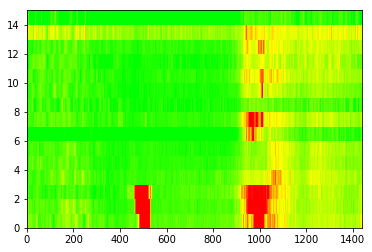

In [180]:
idx = 431  # test: [417,420,431]
print(data.loc[idx])

def vis_one_day_traffic_speed(speed):
    plt.pcolor(speed,cmap=my_cmap, vmin=20, vmax=70)
    
# vis_one_day_traffic_speed(db[257]['label'])
print(type(db[idx]['traffic']))
vis_one_day_traffic_speed(db[idx]['traffic'][:,:,0]) 

In [107]:
# data_test = data.loc[[417,420,431]]
# data_test = data_test.reset_index()

# data_train = data
# data_train = data_train.drop([417,420,431])
# data_train = data_train.reset_index()

## dataloader: load sample from database in batch

## batch added one more dimension to the left

## in case of multi-output and batch = 10, each sample:

## {'traffic':(10,15,1439,3),'weather':(10,15,1439,10),'history':(10,6,15,1439,3),'label':(10,15,1439)}

In [181]:
data_train = data[:-30]
data_train = data_train.reset_index()

data_val = data[-61:]
data_val = data_val.reset_index()

dataset = {}
dataset['train'] = LSTM_SpeedPrediction_database_output_multi_sensor(Traffic[:-30], Weather[:-30], data_train)
dataset['val'] = LSTM_SpeedPrediction_database_output_multi_sensor(Traffic[-61:], Weather[-61:], data_val)

dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=200,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [172]:
# for sample in dataloaders['train']:
#     print('traffic: ',sample['traffic'].shape)
#     print('weather: ',sample['weather'].shape)
#     print('history: ',sample['history'].shape)
#     print('label: ',sample['label'].shape)

In [173]:
'''https://github.com/wkelongws/iemgrid'''
'''Weather: 0:tmpc 1:dwpc 2:smps 3:drct 4:vsby 5:roadtmpc 6:srad 7:snwd 8:pcpn '''

Traffic_max = []
Traffic_min = []
Weather_max = []
Weather_min = []

for i in range(Traffic.shape[-1]):
#     print(i,'max: ',np.max(Traffic[:,:,:,i]))
    Traffic_max.append(np.max(Traffic[:,:,:,i]))
#     print(i,'mean: ',np.mean(Traffic[:,:,:,i]))
#     print(i,'min: ',np.min(Traffic[:,:,:,i]))
    Traffic_min.append(np.min(Traffic[:,:,:,i]))
for i in range(Weather.shape[-1]):
#     print(i,'max: ',np.max(Weather[:,:,:,i]))
    Weather_max.append(np.max(Weather[:,:,:,i]))
#     print(i,'mean: ',np.mean(Weather[:,:,:,i]))
#     print(i,'min: ',np.min(Weather[:,:,:,i]))
    Weather_min.append(np.min(Weather[:,:,:,i]))
    
Min_Max = (Traffic_max,Traffic_min,Weather_max,Weather_min)

In [174]:
Min_Max[3]

[-25.0, -29.0, 0.0, 0.0, 0.0, -20.399999999999999, 0.0, 0.0, -36.0]

## LSTM Prediction Net
## Normalization on the fly. Normalize all numbers ~ (0,1)

In [ ]:
class LSTM_Short_Term_Speed_Pred_Net(nn.Module):
    def __init__(self, input_dim_today, input_dim_history, output_single_sensor = False, \
                 hidden_dim = 16,use_['traffic'].shapegpu = False, use_volume_and_occup = False, \
                 use_weather = False, use_history = True, input_feature = 'raw', Min_Max = Min_Max):
        super(LSTM_Short_Term_Speed_Pred_Net, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.input_dim_today = input_dim_today
        self.input_dim_history = input_dim_history
        self.out_dim = 15
        if output_single_sensor:
            self.out_dim = out_dim = 1
        self.use_gpu = use_gpu
        
        self.use_volume_and_occup = use_volume_and_occup
        self.use_weather = use_weather
        self.use_history = use_history
        assert input_feature in ['raw','linear','CNN'], 'wrong choice for input_feature'
        self.input_feature = input_feature # ['raw','linear','CNN']
        
        '''for on-fly normalization'''
        self.Traffic_max = Min_Max[0]
        self.Traffic_min = Min_Max[1]
        self.Weather_max = Min_Max[2]
        self.Weather_min = Min_Max[3]
        
        if self.input_feature == 'cnn':
            self.CNN_feature_extract = nn.Conv2d(16, 33, (5, 1), stride=(1, 1))
            if self.use_volume_and_occup:
                self.CNN_feature_extract = nn.Conv2d(16, 33, (5, 3), stride=(1, 1))
            if self.use_weather:
                self.CNN_feature_extract = nn.Conv2d(16, 33, (5, 12), stride=(1, 1))
                
        self.lstm_today = nn.LSTMCell(input_dim_today, hidden_dim)
        self.lstm_history = nn.LSTMCell(input_dim_history, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim, out_dim)
        
    def init_hidden(self,input_sample):
        
        batch_size = input_sample['traffic'].shape[0]
        if self.use_gpu:
            return Variable(torch.zeros(batch_size, self.hidden_dim).cuda(), requires_grad=False)
        return Variable(torch.zeros(batch_size, self.hidden_dim), requires_grad=False)

    def forward(self, input_sample, future = 0):
        
        '''reconstruct data from sample'''
        traffic = input_sample['traffic']
        weather = input_sample['weather']
        history = input_sample['history']
        label = input_sample['label']
        
        '''normalize'''
        label = (label - self.Traffic_min[0])/(self.Traffic_max[0]-self.Traffic_min[0])
        for i in range(traffic.shape[-1]):
            traffic[:,:,:,i] = (traffic[:,:,:,i]-self.Traffic_min[i])/(self.Traffic_max[i]-self.Traffic_min[i])
            history[:,:,:,:,i] = (history[:,:,:,i]-self.Traffic_min[i])/(self.Traffic_max[i]-self.Traffic_min[i])
        for i in range(weather.shape[-1]):
            weather[:,:,:,i] = (weather[:,:,:,i]-self.Weather_min[i])/(self.Weather_max[i]-self.Weather_min[i])
        
        
        
        outputs = []
        hidden_state_today = self.init_hidden(input_sample)
        cell_state_today = self.init_hidden(input_sample)
        hidden_state_history = self.init_hidden(input_sample)
        cell_state_history = self.init_hidden(input_sample)
        
        for i in range(input.data.shape[0]):
            input_t = input[i]
#             print('i: ',i)
#             print('input_t: ',input_t.data.shape)
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
#         print('outputs.data.shape: ',outputs.data.shape)
        return outputs

In [193]:
for sample in dataloaders['train']:
#     b = sample['traffic'].shape
    print(type(sample['traffic']))
    print('traffic: ',sample['traffic'].shape)
    print('weather: ',sample['weather'].shape)
    print('history: ',sample['history'].shape)
    print('label: ',sample['label'].shape)

<class 'torch.FloatTensor'>
traffic:  torch.Size([200, 15, 1439, 3])
weather:  torch.Size([200, 15, 1439, 9])
history:  torch.Size([200, 6, 15, 1440, 3])
label:  torch.Size([200, 15, 1439])
<class 'torch.FloatTensor'>
traffic:  torch.Size([200, 15, 1439, 3])
weather:  torch.Size([200, 15, 1439, 9])
history:  torch.Size([200, 6, 15, 1440, 3])
label:  torch.Size([200, 15, 1439])
<class 'torch.FloatTensor'>
traffic:  torch.Size([17, 15, 1439, 3])
weather:  torch.Size([17, 15, 1439, 9])
history:  torch.Size([17, 6, 15, 1440, 3])
label:  torch.Size([17, 15, 1439])


In [189]:
a = torch.from_numpy(np.array([[[1,2],[3,4]],[[2,5],[6,8]]])).float()
a


(0 ,.,.) = 
  1  2
  3  4

(1 ,.,.) = 
  2  5
  6  8
[torch.FloatTensor of size 2x2x2]

In [192]:
(a-1)/(8-1)


(0 ,.,.) = 
  0.0000  0.1429
  0.2857  0.4286

(1 ,.,.) = 
  0.1429  0.5714
  0.7143  1.0000
[torch.FloatTensor of size 2x2x2]

In [140]:
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
input = autograd.Variable(torch.randn(20, 16, 50, 100))
output = m(input)
print(input.shape)
print(output.shape)

torch.Size([20, 16, 50, 100])
torch.Size([20, 33, 26, 100])


In [146]:

input =  Variable(torch.from_numpy(np.zeros((10,1,15,15))))
type(input)

torch.autograd.variable.Variable

In [156]:
type(torch.from_numpy(np.random.randn(10,1,15,15)))

torch.DoubleTensor

In [160]:
input =  Variable(torch.from_numpy(np.random.randn(10,1,15,3)).float())
cnn = nn.Conv2d(1, 3, (5, 3), stride=(1, 1))
output = cnn(input)
print(input.shape)
print(output.shape)

torch.Size([10, 1, 15, 3])
torch.Size([10, 3, 11, 1])


In [ ]:
def customized_loss(preds, targets):
    
    preds = preds.view(preds.data.shape[0]*preds.data.shape[1],-1)
    targets = targets.view(targets.data.shape[0]*targets.data.shape[1],-1)
    
    pdist = nn.PairwiseDistance(p=2)
    
    output = pdist(preds, targets)

    loss = sum(output)/output.data.shape[0]
    
    return loss

In [ ]:
use_gpu = torch.cuda.is_available()
# use_gpu = False

model = LSTM_perVehiclePrediction_Net(hidden_dim = 51, traj_dim = 2, use_gpu = use_gpu)

if use_gpu:
    model = model.cuda()

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
def train_LSTM_perVehiclePrediction_Net(model,dataloaders, criterion, optimizer, dataset_sizes, num_epochs=10):
    since = time.time()
#     timeSince(since)
    best_model_wts = model.state_dict()
    best_loss = 100000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
#                 print(data)
                # get the inputs
                inputs = data['traj']
                labels = data['target']
                inputs = inputs.permute(1,0,2)
#                 print('labels.shape: ',labels.shape)
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())model_ft = train_LSTM_perVehiclePrediction_Net(model,dataloaders, criterion, optimizer, dataset_sizes, num_epochs=2000)
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                model.zero_grad()
                optimizer.zero_grad()
                
                # Also, we need to clear out the hidden state of the LSTM,
                # detaching it from its history on the last instance.
#                 model.hidden = model.init_hidden()
                
                # forward
                outputs = model(inputs)
                
                # loss function
                loss = customized_loss(outputs, labels)
#                 loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f} total elapsed time: {}'.format(phase, epoch_loss, timeSince(since)))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()
                torch.save(best_model_wts, 'Best_LSTM_Weights')
                print('Weights saved to "Best_LSTM_Weights"')

        print()

    print('Training complete in {}'.format(timeSince(since)))
    print('Best val loss: {:4f}'.format(best_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model, 'Model_with_Best_LSTM_Weights')
    print('Model saved to "Model_with_Best_LSTM_Weights"')
    return model

In [ ]:
model_ft = train_LSTM_perVehiclePrediction_Net(model,dataloaders, criterion, optimizer, dataset_sizes, num_epochs=2000)